# Extra Time Series Modeling: FFT-based Features, ARMA, ARIMA, and Prophet

This notebook demonstrates extra–grade work by incorporating frequency‐domain features from a Fast Fourier Transform (FFT) and then modeling the NYC taxi rides time series using three approaches:

• **ARMA Modeling:** Using an ARIMA model with d=0 (i.e. ARMA) and including Fourier terms as regressors.
• **ARIMA Modeling:** Using an ARIMA model (with d=1) with Fourier exogenous regressors.
• **Prophet Modeling:** Fitting Facebook’s Prophet on the aggregated data.

The Fourier features are created by computing the FFT on the hourly aggregated target series, selecting the two dominant frequencies (ignoring the zero frequency), and then adding sine and cosine terms based on these frequencies.

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:

# For ARMA and ARIMA modeling
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Prophet (make sure you have installed prophet via pip install prophet)
from prophet import Prophet

from numpy.fft import fft, fftfreq

sns.set(style="whitegrid")

## Load and Aggregate Data

We load the transformed taxi data (the same as your 11_lgm_hyper.ipynb) and aggregate it by hour.

In [ ]:
from pathlib import Path

import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.config import TRANSFORMED_DATA_DIR  # Ensure this is defined in your project

# Load the feature engineered data (assumed to be saved in parquet)
df = pd.read_parquet(TRANSFORMED_DATA_DIR / "tabular_data.parquet")

df['pickup_hour'] = pd.to_datetime(df['pickup_hour'])

# Aggregate by hour – here we sum the target (number of rides) per hour.
ts = df.set_index('pickup_hour')['target'].resample('H').sum().fillna(0)

plt.figure(figsize=(12,6))
plt.plot(ts.index, ts.values)
plt.title("Hourly Aggregated Taxi Rides")
plt.xlabel("Time")
plt.ylabel("Number of Rides")
plt.show()


In [ ]:
ts.head(10)

pickup_hour
2023-01-29 00:00:00    5404
2023-01-29 01:00:00       0
2023-01-29 02:00:00       0
2023-01-29 03:00:00       0
2023-01-29 04:00:00       0
2023-01-29 05:00:00       0
2023-01-29 06:00:00       0
2023-01-29 07:00:00       0
2023-01-29 08:00:00       0
2023-01-29 09:00:00       0
Freq: h, Name: target, dtype: int16


## Incorporate FFT-Based Features
Compute the FFT of the entire time series and extract its power spectrum. Then, choose the two dominant (nonzero) frequencies and create corresponding sine and cosine regressors for each timestamp.

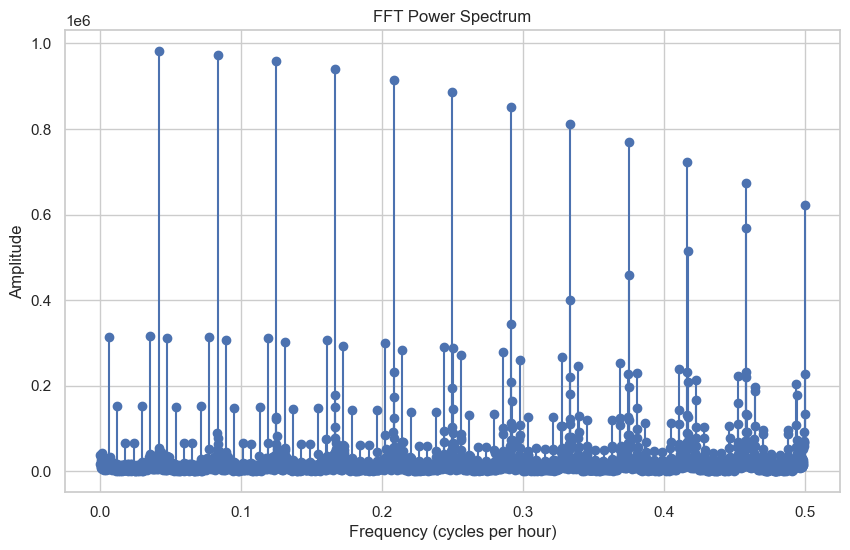

Dominant Frequencies: [0.0416615 0.083323 ]


,sin_0.0417,cos_0.0417,sin_0.0833,cos_0.0833
pickup_hour,,,,
2023-01-29 00:00:00,0.000000,1.000000,0.000000,1.000000
2023-01-29 01:00:00,0.258788,0.965934,0.499944,0.866058
2023-01-29 02:00:00,0.499944,0.866058,0.865960,0.500112
2023-01-29 03:00:00,0.707038,0.707176,1.000000,0.000195
2023-01-29 04:00:00,0.865960,0.500112,0.866155,-0.499775


In [ ]:

N = len(ts)
# Create a time index (in hours)
t = np.arange(N)
fft_vals = fft(ts.values)
fft_freq = fftfreq(N, d=1)  # sampling frequency = 1 per hour

# Only use the positive frequencies (ignore zero)
mask = fft_freq > 0
fft_freq_pos = fft_freq[mask]
fft_power = np.abs(fft_vals[mask])

# Plot the power spectrum
plt.figure(figsize=(10,6))
plt.stem(fft_freq_pos, fft_power, basefmt=" ")
plt.xlabel("Frequency (cycles per hour)")
plt.ylabel("Amplitude")
plt.title("FFT Power Spectrum")
plt.show()

# Pick the two dominant frequencies (ignoring the zero DC component)
top_indices = np.argsort(fft_power)[-2:]
dominant_freqs = fft_freq_pos[top_indices]
dominant_freqs = np.sort(dominant_freqs)  # sort for consistency
print("Dominant Frequencies:", dominant_freqs)

# Create Fourier terms for these frequencies
fourier_data = {}
for freq in dominant_freqs:
    fourier_data[f'sin_{freq:.4f}'] = np.sin(2 * np.pi * freq * t)
    fourier_data[f'cos_{freq:.4f}'] = np.cos(2 * np.pi * freq * t)
fourier_terms = pd.DataFrame(fourier_data, index=ts.index)
fourier_terms.head()

## Prepare Model Data

Combine the aggregated target series and the Fourier terms into a single DataFrame. This final DataFrame will be used to fit our time series models.

In [ ]:
df_model = pd.DataFrame({'target': ts})
df_model = df_model.join(fourier_terms)
df_model.head()

,target,sin_0.0417,cos_0.0417,sin_0.0833,cos_0.0833
pickup_hour,,,,,
2023-01-29 00:00:00,5404,0.000000,1.000000,0.000000,1.000000
2023-01-29 01:00:00,0,0.258788,0.965934,0.499944,0.866058
2023-01-29 02:00:00,0,0.499944,0.866058,0.865960,0.500112
2023-01-29 03:00:00,0,0.707038,0.707176,1.000000,0.000195
2023-01-29 04:00:00,0,0.865960,0.500112,0.866155,-0.499775


## Split Data into Training and Testing Sets

We’ll use 80% of the data for training and the remaining 20% for testing.

In [ ]:
split_point = int(len(df_model) * 0.8)
train_data = df_model.iloc[:split_point]
test_data = df_model.iloc[split_point:]
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)


# Prepare exogenous regressors (the Fourier terms)
exog_train = train_data.drop(columns=['target'])
exog_test = test_data.drop(columns=['target'])

Training data shape: (6452, 5)
Testing data shape: (1613, 5)



## ARMA Modeling (ARIMA with d=0)
We fit an ARIMA model with order (2,0,2) (an ARMA model) on the training data using the Fourier terms as exogenous regressors and then forecast on the test set.

                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                 6452
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -50198.900
Date:                Wed, 05 Mar 2025   AIC                         100417.801
Time:                        15:07:10   BIC                         100485.522
Sample:                    01-29-2023   HQIC                        100441.232
                         - 10-24-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        120.0715     17.582      6.829      0.000      85.612     154.531
sin_0.0417   -25.0090     22.838     -1.095      0.273     -69.770      19.752
cos_0.0417   238.3381     24.201      9.848      0.0

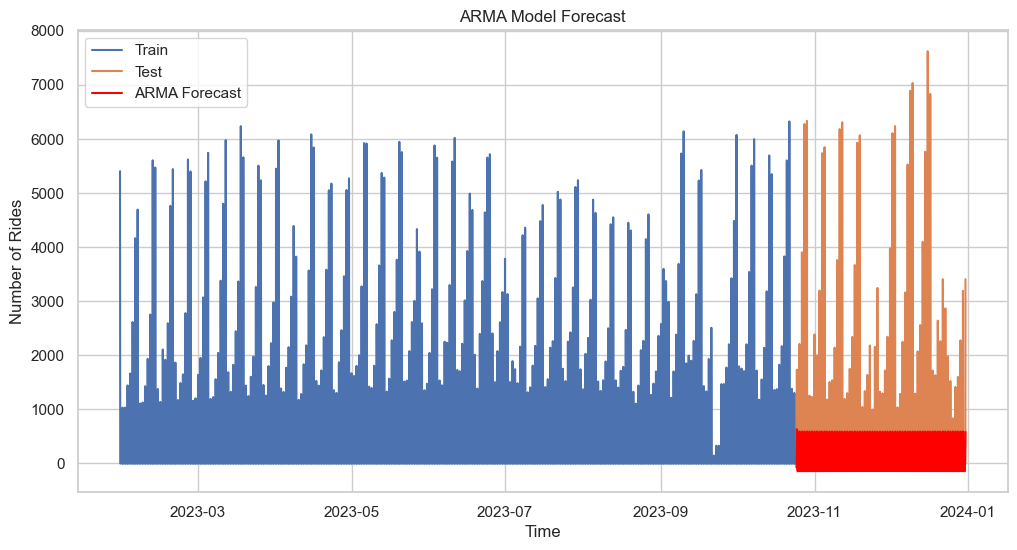

ARMA MAE: 277.5149926228057


In [ ]:

arma_order = (2, 0, 2)
arma_model = ARIMA(train_data['target'], exog=exog_train, order=arma_order)
arma_results = arma_model.fit()
print(arma_results.summary())

# Forecast on test period
arma_forecast = arma_results.predict(start=test_data.index[0],
                                     end=test_data.index[-1],
                                     exog=exog_test)

plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data['target'], label='Train')
plt.plot(test_data.index, test_data['target'], label='Test')
plt.plot(arma_forecast.index, arma_forecast, label='ARMA Forecast', color='red')
plt.legend()
plt.title("ARMA Model Forecast")
plt.xlabel("Time")
plt.ylabel("Number of Rides")
plt.show()

arma_mae = np.mean(np.abs(test_data['target'] - arma_forecast))
print("ARMA MAE:", arma_mae)



## ARIMA Modeling (with d=1)

Here we assume that differencing the data once (d=1) is beneficial. The model order is set to (2,1,2) and the Fourier terms are kept as exogenous regressors.

c:\Users\ADMIN\anaconda3\envs\sp25_taxi\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                 6452
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -50396.201
Date:                Wed, 05 Mar 2025   AIC                         100810.401
Time:                        15:07:32   BIC                         100871.349
Sample:                    01-29-2023   HQIC                        100831.489
                         - 10-24-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin_0.0417   -28.3949     31.823     -0.892      0.372     -90.767      33.977
cos_0.0417   237.7669     24.237      9.810      0.000     190.264     285.270
sin_0.0833   -51.0395     24.149     -2.114      0.0

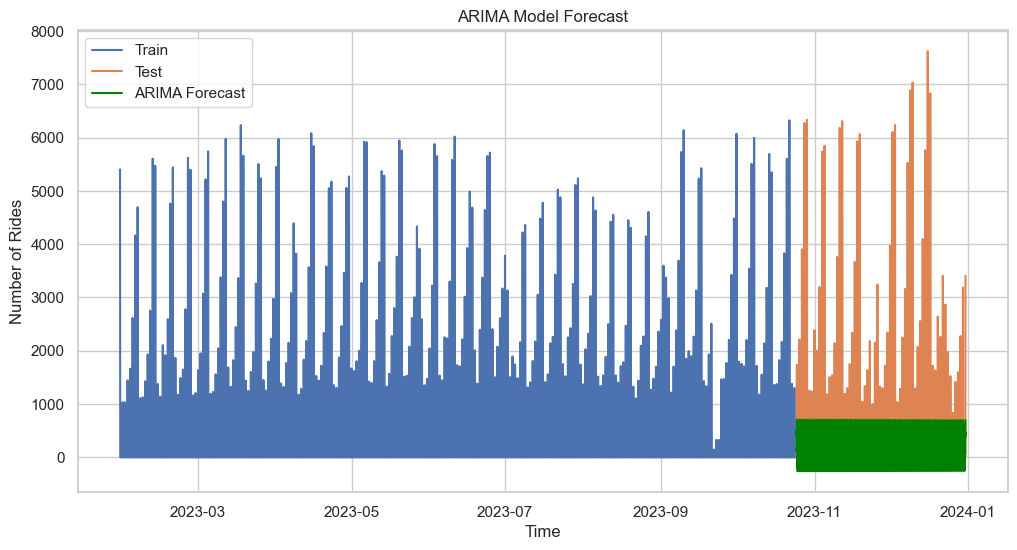

ARIMA MAE: 292.102798100871


In [ ]:

arima_order = (2, 1, 2)
arima_model = ARIMA(train_data['target'], exog=exog_train, order=arima_order)
arima_results = arima_model.fit()
print(arima_results.summary())

arima_forecast = arima_results.predict(start=test_data.index[0],
                                       end=test_data.index[-1],
                                       exog=exog_test,
                                       dynamic=False)
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data['target'], label='Train')
plt.plot(test_data.index, test_data['target'], label='Test')
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Forecast', color='green')
plt.legend()
plt.title("ARIMA Model Forecast")
plt.xlabel("Time")
plt.ylabel("Number of Rides")
plt.show()

arima_mae = np.mean(np.abs(test_data['target'] - arima_forecast))
print("ARIMA MAE:", arima_mae)


## Prophet Modeling

Prophet requires a DataFrame with columns `ds` (date) and `y` (target). We prepare the data, fit the model (using weekly seasonality) and then forecast the future values.

In [ ]:

# Prepare Prophet data
df_prophet = df_model.reset_index().rename(columns={'index': 'ds', 'target': 'y'})
df_prophet.head()

# Split into training and testing sets (using the same split point)
train_prophet = df_prophet.iloc[:split_point]
test_prophet = df_prophet.iloc[split_point:]

# Initialize and fit Prophet; we disable yearly and daily seasonality and keep weekly seasonality.
model_prophet = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
model_prophet.fit(train_prophet[['ds', 'y']])

# Create future dataframe covering test period (hourly frequency)
future = model_prophet.make_future_dataframe(periods=len(test_prophet), freq='H')
forecast = model_prophet.predict(future)

# Plot Prophet forecast
fig1 = model_prophet.plot(forecast)
plt.title("Prophet Forecast")
plt.xlabel("Time")
plt.ylabel("Number of Rides")
plt.show()

# Evaluate Prophet forecast on test set
forecast_df = forecast.set_index('ds')
prophet_forecast = forecast_df.loc[test_prophet['ds'], 'yhat']
prophet_mae = np.mean(np.abs(test_prophet['y'] - prophet_forecast))
print("Prophet MAE:", prophet_mae)

AttributeError: 'Prophet' object has no attribute 'stan_backend'


## Conclusion

In this notebook we performed extra–grade tasks by:

• Incorporating FFT–based features: We computed the FFT of the hourly aggregated rides, selected the two dominant frequencies, and created sine/cosine regressors.

• Modelled the resulting time series using three methods:

- ARMA (ARIMA with d=0)
- ARIMA (with d=1)
- Prophet
Compare the forecast plots and MAE values to assess model performance. Adjust orders or exogenous regressors as needed for further improvements.